### Q-Planning

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

### Tabular Dyna-Q

In [ ]:
RG = np.random.RandomState(12)
# Initialize Q(s, a) and Model(s, a) for all s ∈ S and a ∈ A(s)
def DynaQPlus(Q, PlanningQ, ModelReward, ModelState1, Sequence, n, alpha, gamma, UNOBSERVED):
    global RG
    # Loop forever:
        # (a) S ← current (nonterminal) state
        # (b) A ← ε-greedy(S, Q)
        # (c) Take action A; observe resultant reward, R, and state, S`
    for state, is_terminal, next_state, action, reward in Sequence:
        # (d) Q(S, A) ← Q(S, A) + α*[R + γ*max(a)Q(S`, a) - Q(S, A)]
        Q[state][action] = Q[state][action] + alpha*( 
            reward + gamma*max(Q[next_state]) - Q[state][action])
        # (e) Model(S, A) ← R, S` (assuming deterministic environment)
        ModelReward[state][action] = reward
        ModelState1[state][action] = next_state
        # (f) Loop repeat n times:
        observed = np.transpose(np.nonzero((ModelState1 != UNOBSERVED).all(axis=-1)))
        for sample in RG.randint(len(observed), size=n):
            #   S ← random previously observed state
            #   A ← random action previously taken in S
            SA = tuple(observed[sample])
            ### S = SA[:-1]
            ### A = SA[-1]
            #   R, S` ← Model(S, A)
            R = ModelReward[SA]
            S1 = tuple(ModelState1[SA])
            #   Q(S, A) ← Q(S, A) + α*[R + γ*max(a)Q(S`, a) - Q(S, A)]
            PlanningQ[SA] = PlanningQ[SA] + alpha*(
                R + gamma*max(PlanningQ[S1]) - PlanningQ[SA])

### Generic sequence generator

In [ ]:
class SequenceGeneratorPlus:
    def __init__(self, getAction, getStartState, getTransition, episode_imax=1, steps_max=0,
                callBack=None):
        self.episode_imax = episode_imax
        self.get_action = getAction
        self.get_start_state = getStartState
        self.get_transition = getTransition
        self.steps_max = steps_max
        self.callback = callBack

    def __iter__(self):
        self.episode_i=1
        self.state = self.get_start_state(self.episode_i)
        self.step_i = 0
        return self

    def __next__(self):
        if self.episode_imax > 0 and self.episode_i > self.episode_imax or \
            self.steps_max > 0 and self.step_i > self.steps_max:
            raise StopIteration

        action = self.get_action(self.state, self.episode_i)
        keep_state = self.state
        is_terminal, self.state, reward = self.get_transition(keep_state, action)
        if self.callback:
            self.callback(self, keep_state, is_terminal, self.state, action, reward)
        self.step_i += 1
        self.episode_i += int(is_terminal)
        return keep_state, is_terminal, self.state, action, reward
    
REWARD_I = 4
STATE_I = 0

# TODO: rid of global variables
random_generator = np.random.RandomState(11)

class EpsilonGreedyPolicy:
    def __init__(self, Q, Epsilon=0.1):
        self.Q = Q;
        self.epsilon = Epsilon

    def __call__(self, state, episode_i=1):
        global random_generator
        q = self.Q[state]
        if random_generator.rand(1)[0] < self.epsilon:
            val = random_generator.randint(0,len(q))
        else:
            val = np.argmax(q)
        return val

### Auxiliary classes

In [ ]:
class TotalRewardCallback:
    def __init__(self, period):
        self.period = period
        self.RewardSum = 0.0
        self.TotalReward = []

    def __call__(self, seq_gen, s0, isterm, s1, a, r):
        self.RewardSum += r
        if seq_gen.step_i % self.period == 0: 
            self.TotalReward.append(self.RewardSum)

class TimestampCallback:
    def __init__(self, planningQ, chainCallback=None):
        self.planningQ = planningQ
        self.chain = chainCallback

    def __call__(self, seq_gen, s0, isterm, s1, a, r):
        self.planningQ.timestamp[s0][a] = seq_gen.step_i
        self.planningQ.step = seq_gen.step_i
        self.chain(seq_gen, s0, isterm, s1, a, r)

class SwitchMazeCallback:
    def __init__(self, transitionFunc, switch_step, switch_maze, chainCallback=None):
        self.chain = chainCallback
        self.transition = transitionFunc
        self.switch_step = switch_step
        self.switch_maze = switch_maze

    def __call__(self, seq_gen, s0, isterm, s1, a, r):
        self.chain(seq_gen, s0, isterm, s1, a, r)
        if seq_gen.step_i == self.switch_step: 
            self.transition.setMaze(self.switch_maze)

class getMazeTransition:
    def __init__(self, original_func, Maze):
        self.func = original_func
        self.maze = Maze

    def __call__(self, state, action):
        return self.func(self.maze, state, action)

    def setMaze(self, Maze):
        self.maze = Maze
        
class QPlus:
    def __init__(self, Q, factor):
        self.Q = Q
        self.timestamp = np.zeros(shape = Q.shape, dtype=int)
        self.factor = factor
        self.step = 0

    def __getitem__(self, key):
        return self.Q[key] + self.factor*np.sqrt(self.step - self.timestamp[key])

    def __setitem__(self, key, value):
        self.Q[key] = value

### Setup of Maze Problem

In [ ]:
maze_shape = (6,9,)
maze_obstacles_1 = [[2,1,3,9]]
start_cell_1 = (0,3)
target_cell_1 = (5,8)

maze_obstacles_2 = [[2,1,3,8]]
maze_obstacles_3 = [[2,2,5,3], [1,5,2,6], [3,7,6,8]]
OBSTACLE_TAG = 0
START_TAG = 2
start_cell = (0,3)
TARGET_TAG = 3
target_cell = (5,8)

def buildMaze(shape, obstacles, start, target):
    maze = np.ones(shape, dtype = np.uint8)
    for begin_row, begin_column, end_row, end_column in obstacles:
        for r in range(begin_row, end_row):
            for c in range(begin_column, end_column):
                maze[r,c] = OBSTACLE_TAG
    maze[start] = START_TAG
    maze[target] = TARGET_TAG
    return maze

maze1 = buildMaze(maze_shape, maze_obstacles_1, start_cell, target_cell)
maze2 = buildMaze(maze_shape, maze_obstacles_2, start_cell, target_cell)

In [ ]:
# Actions legend: Up, Right, Down, Left
ACTIONS = np.array([[1,0], [0,1], [-1,0], [0,-1]])
ACTIONS_NUM = len(ACTIONS)
NO_REWARD = 0
REWARD = 1
UNOBSERVED = (-1,-1,)
shape = maze_shape + (ACTIONS_NUM,)

def maze_getTransition(maze, getStartState, state, action):
    next_state = tuple(np.array(list(state)) + ACTIONS[action])
    if not (next_state in np.ndindex(maze.shape) and maze[next_state] > 0):
        return (False, state, NO_REWARD)
    elif maze[next_state] == TARGET_TAG:
        return (True, getStartState(), REWARD)

    return (False, next_state, NO_REWARD)

### Shortcut Maze Problem Setup

In [52]:
alpha = 0.1
gamma = 0.95
epsilon = 0.1
n = 50
bonus_reward_factor = 2.e-4

def setupSortcutMazeProblem():
    Q = np.zeros(shape)
    ModelReward = np.zeros(shape)
    ModelState1 = np.full(shape+(2,),-1)
    
    maze_obstacles_1 = [[2,1,3,9]]
    maze_obstacles_2 = [[2,1,3,8]]
    start_cell = (0,3)
    target_cell = (5,8)

    maze1 = buildMaze(maze_shape, maze_obstacles_1, start_cell, target_cell)
    maze2 = buildMaze(maze_shape, maze_obstacles_2, start_cell, target_cell)

    getStartCell = lambda e=1: start_cell
    total_reward_callback = TotalRewardCallback(100)

    shortcut_maze_callback = SwitchMazeCallback(
        getMazeTransition(lambda m,s,a: maze_getTransition(m, getStartCell, s, a), maze1),
        3000,
        maze2,
        total_reward_callback
        )
    planning = QPlus(Q, bonus_reward_factor)
    timestamp_callback = TimestampCallback(planning, shortcut_maze_callback)
    return (Q, ModelReward, ModelState1, planning, timestamp_callback, total_reward_callback,
            shortcut_maze_callback, getStartCell)

In [54]:
# setup and run Dyna-Q
Q, ModelReward, ModelState1, planning, timestamp_callback, DaynaQ_total_reward, \
    switch_callback, getStartCell = setupSortcutMazeProblem()

random_generator.seed(9)
gen = SequenceGeneratorPlus(EpsilonGreedyPolicy(Q, epsilon),
                        getStartCell,
                        switch_callback.transition,
                        0,
                        6000-1,
                        switch_callback
                       )

RG.seed(3)
DynaQPlus(Q, Q, ModelReward, ModelState1, iter(gen), n, alpha, gamma, UNOBSERVED)

In [55]:
# setup and run Dyna-Q+
Q, ModelReward, ModelState1, planning, timestamp_callback, DaynaQPlus_total_reward, \
    switch_callback, getStartCell = setupSortcutMazeProblem()

random_generator.seed(9)
gen = SequenceGeneratorPlus(EpsilonGreedyPolicy(Q, epsilon),
                        getStartCell,
                        switch_callback.transition,
                        0,
                        6000-1,
                        timestamp_callback
                       )

# Dyna-Q+ specific:
for i in np.ndindex(ModelState1.shape[:-1]):
    ModelState1[i] = i[:-1]

#sequence, test_sequence = itertools.tee(gen,2)
RG.seed(3)
DynaQPlus(Q, planning, ModelReward, ModelState1, iter(gen), n, alpha, gamma, UNOBSERVED)

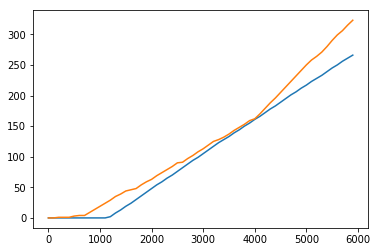

In [56]:
plt.plot(range(0,6000,100), DaynaQ_total_reward.TotalReward)
plt.plot(range(0,6000,100), DaynaQPlus_total_reward.TotalReward)

### Blocking Maze Problem Setup

In [ ]:
alpha = 0.1
gamma = 0.95
n = 40

def setupBlockingMazeProblem():
    Q = np.zeros(shape)
    ModelReward = np.zeros(shape)
    ModelState1 = np.full(shape+(2,),-1)
    start_cell = (0,3)

    blockMaze1 = buildMaze(maze_shape, [[2,0,3,8]], start_cell, (5,8))
    blockMaze2 = buildMaze(maze_shape, [[2,1,3,9]], start_cell, (5,8))

    getStartCell = lambda e=1: start_cell
    total_reward_callback = TotalRewardCallback(100)

    blocking_maze_callback = SwitchMazeCallback(
        getMazeTransition(lambda m,s,a: maze_getTransition(m, getStartCell, s, a), blockMaze1),
        1000,
        blockMaze2,
        total_reward_callback
        )
    planning = QPlus(Q, 2.e-4)
    timestamp_callback = TimestampCallback(planning, blocking_maze_callback)
    return (Q, ModelReward, ModelState1, planning, timestamp_callback, total_reward_callback,
            blocking_maze_callback, getStartCell)

In [ ]:
# setup and run Dyna-Q
Q, ModelReward, ModelState1, planning, timestamp_callback, DaynaQ_total_reward, \
    switch_callback, getStartCell = setupBlockingMazeProblem()

random_generator.seed(2)
gen = SequenceGeneratorPlus(EpsilonGreedyPolicy(Q, 0.1),
                        getStartCell,
                        switch_callback.transition,
                        0,
                        3000-1,
                        switch_callback
                       )

RG = np.random.RandomState(12)
DynaQPlus(Q, Q, ModelReward, ModelState1, iter(gen), n, alpha, gamma, UNOBSERVED)

In [ ]:
# setup and run Dyna-Q+
Q, ModelReward, ModelState1, planning, timestamp_callback, DaynaQPlus_total_reward, \
    switch_callback, getStartCell = setupBlockingMazeProblem()

random_generator.seed(2)
gen = SequenceGeneratorPlus(EpsilonGreedyPolicy(Q, 0.1),
                        getStartCell,
                        switch_callback.transition,
                        0,
                        3000-1,
                        timestamp_callback
                       )

# Dyna-Q+ specific:
for i in np.ndindex(ModelState1.shape[:-1]):
    ModelState1[i] = i[:-1]

#sequence, test_sequence = itertools.tee(gen,2)
RG = np.random.RandomState(12)
DynaQPlus(Q, planning, ModelReward, ModelState1, iter(gen), n, alpha, gamma, UNOBSERVED)

In [ ]:
plt.plot(range(0,3000,100), DaynaQ_total_reward.TotalReward)
plt.plot(range(0,3000,100), DaynaQPlus_total_reward.TotalReward)

#### Exercise 8.4

In [57]:
alpha = 0.1
gamma = 0.95
epsilon = 0.1
n = 50
bonus_reward_factor = 2.e-4

Q = np.zeros(shape)
ModelReward = np.zeros(shape)
ModelState1 = np.full(shape+(2,),-1)

maze_obstacles_1 = [[2,1,3,9]]
maze_obstacles_2 = [[2,1,3,8]]
start_cell = (0,3)
target_cell = (5,8)

maze1 = buildMaze(maze_shape, maze_obstacles_1, start_cell, target_cell)
maze2 = buildMaze(maze_shape, maze_obstacles_2, start_cell, target_cell)

getStartCell = lambda e=1: start_cell
total_reward_callback = TotalRewardCallback(100)

shortcut_maze_callback = SwitchMazeCallback(
    getMazeTransition(lambda m,s,a: maze_getTransition(m, getStartCell, s, a), maze1),
    3000,
    maze2,
    total_reward_callback
    )
planning = QPlus(Q, bonus_reward_factor)
timestamp_callback = TimestampCallback(planning, shortcut_maze_callback)

In [58]:
random_generator.seed(9)
gen = SequenceGeneratorPlus(EpsilonGreedyPolicy(planning, epsilon),
                        getStartCell,
                        shortcut_maze_callback.transition,
                        0,
                        6000-1,
                        timestamp_callback
                       )
RG.seed(3)
DynaQPlus(Q, Q, ModelReward, ModelState1, iter(gen), n, alpha, gamma, UNOBSERVED)

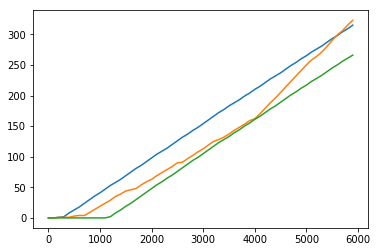

In [59]:
plt.plot(range(0,6000,100), total_reward_callback.TotalReward)
plt.plot(range(0,6000,100), DaynaQPlus_total_reward.TotalReward)
plt.plot(range(0,6000,100), DaynaQ_total_reward.TotalReward)

### Testing

In [ ]:
observed = np.transpose(np.nonzero((ModelState1 != UNOBSERVED).all(axis=-1)))
len(observed)

In [ ]:
maze = maze1
getStartCell = lambda e=1: start_cell_1
random_generator.seed(1)
gen = SequenceGenerator(EpsilonGreedyPolicy(Q, 0.1),
                        getStartCell,
                        lambda s,a: maze_getTransition(maze, getStartCell, s, a),
                        1
                       )
sequence = iter(gen)

In [ ]:
len(list(sequence))

In [ ]:
Q = np.zeros(shape)
maze = buildMaze(maze_shape, maze_obstacles_1, start_cell_1, target_cell_1)

for seed_ in range(0,50):
    random_generator.seed(seed_)
    gen = SequenceGenerator(EpsilonGreedyPolicy(Q, 0.1),
                    lambda e: start_cell,
                    lambda s,a: maze_getTransition(maze, s, a),
                    1,
                    20000,
                   )
    sequence = iter(gen)
    if len(list(sequence)) < 20000: break
        
seed_

### Dyna Maze Setup

In [ ]:
epsilon = 0.1
start_cell = (3,0)
target_cell = (5,8)
Maze3 = buildMaze(maze_shape, maze_obstacles_3, start_cell, target_cell)

class DynaMazeLearning:
    def __init__(self, shape):
        self.Q = np.zeros(shape)
        self.ModelReward = np.zeros(shape)
        self.ModelState1 = np.full(shape+(2,),-1)
        
setup1 = DynaMazeLearning(shape)
setup1.Q[...,1] = 1.e-9

In [ ]:
steps_num = np.zeros(shape=(50,), dtype=np.int32)

def callback(e,s,r):
    global steps_num
    steps_num[e-1] = s

random_generator.seed(3)
gen = SequenceGenerator(EpsilonGreedyPolicy(setup1.Q, epsilon),
                lambda e: start_cell,
                lambda s,a: maze_getTransition(Maze3, s, a),
                50,
                0,
                callback
               )
sequence = iter(gen)
#len(list(sequence)), steps_num[0]

In [ ]:
alpha = 0.1
gamma = 0.95

In [ ]:
n = 50
RG.seed(1)

DynaQ(setup1.Q, setup1.ModelReward, setup1.ModelState1, sequence, n, alpha, gamma, UNOBSERVED)

### Run Dyna Maze 3 times with n=0, n=5, n=50

In [ ]:
rate = []

for n in [0,5,50]:
    random_generator.seed(3)
    setup1 = Learinig3(shape)
    setup1.Q[...,1] = 1.e-9
    
    gen = SequenceGenerator(EpsilonGreedyPolicy(setup1.Q, epsilon),
                    lambda e: start_cell,
                    lambda s,a: maze_getTransition(Maze3, s, a),
                    50,
                    0,
                    callback
                   )
    sequence = iter(gen)
    
    RG.seed(5)
    DynaQPlus(setup1.Q, setup1.Q, setup1.ModelReward, setup1.ModelState1, sequence, n, alpha, gamma, UNOBSERVED)
    rate.append([steps_num[j]-steps_num[j-1] for j in range(1,len(steps_num))])

Plot the number of steps in each episode (excluding the first one) for all the three runs.

In [ ]:
plt.plot(rate[0])
plt.plot(rate[1])
plt.plot(rate[2])

### Draw the maze

In [ ]:
maze = maze1
f = plt.figure(num=None, figsize=tuple(reversed(maze.shape)), dpi=80, facecolor='w', edgecolor='k')
plt.pcolor(maze, figure=f)